In [46]:
!pip install cdlib

In [1]:
import pandas as pd
import networkx as nx, matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score, completeness_score, homogeneity_score
import itertools
from node2vec import Node2Vec
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np
from cdlib import algorithms
import time
import seaborn as sns


Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy', 'infomap', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg'}


# Data Set up

In [2]:
########### LASTFM DATASET
# # Download and save the lastfm_asia_edges.csv in the required format
# # Download link: https://snap.stanford.edu/data/feather-lastfm-social.html
# # Data source: 
#     # Author: Benedek Rozemberczki and Rik Sarkar
#     # Title: Characteristic Functions on Graphs: Birds of a Feather, from Statistical Descriptors to Parametric Models
#     # Year: 2020
    
# lastfm_edges=pd.read_csv(r'data/lastfm_asia/lastfm_asia_edges.csv')


In [2]:
########### EMAIL DATASET
# https://snap.stanford.edu/data/email-Eu-core.html
# Source:
#     Hao Yin, Austin R. Benson, Jure Leskovec, and David F. Gleich. "Local Higher-order Graph Clustering." In Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. 2017.
#     J. Leskovec, J. Kleinberg and C. Faloutsos. Graph Evolution: Densification and Shrinking Diameters. ACM Transactions on Knowledge Discovery from Data (ACM TKDD), 1(1), 2007.

email_edges = pd.read_csv(r'data/email_eu/email-Eu-core.txt', sep=' ')
email_edges = email_edges.rename(columns={'0':'node_1', '1':'node_2'})

## Filter out self loops
email_edges = email_edges[email_edges['node_1'] != email_edges['node_2']]

truth = pd.read_csv('data/email_eu/email-Eu-core-department-labels.txt', sep=' ')
truth.columns=['node','label']
print('Total number of ground truth communities:',truth.label.nunique())
display(email_edges, truth)

Total number of ground truth communities: 42


,node_1,node_2
0,2,3
1,2,4
2,5,6
3,5,7
4,8,9
...,...,...
25565,420,143
25566,174,859
25567,440,460
25568,52,786


,node,label
0,1,1
1,2,21
2,3,21
3,4,21
4,5,25
...,...,...
999,1000,4
1000,1001,21
1001,1002,1
1002,1003,6


In [50]:
########### CONGRESS DATASET
# ## Download and save the congresslist.edgelist in the required format
# ## Download link : https://snap.stanford.edu/data/congress-twitter.html
# ## Data source: C.G. Fink, K. Fullin, G. Gutierrez, N. Omodt, S. Zinnecker, 
# ## G. Sprint, and S. McCulloch: A centrality measure for quantifying spread 
# ## on weighted, directed networks. Physica A, 2023.

# G = nx.read_edgelist('data/congress_network/congress.edgelist')

# transition_G = nx.google_matrix(G)
# transition_G=pd.DataFrame(transition_G)

# # Save to Matrix format in txt (transpose to make it column wise stochastic)
# transition_G.T.to_csv('data/matrix-congress.txt', sep=' ', index=True, header=False)

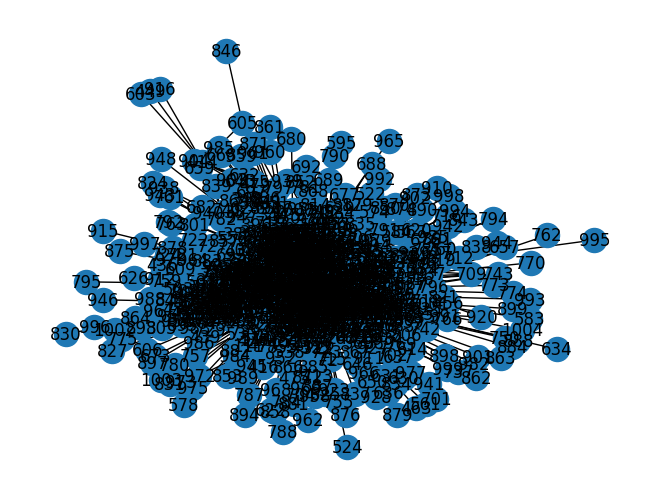

In [52]:
# Create graph
G_lastfm = nx.from_pandas_edgelist(email_edges, 'node_1', 'node_2')

# Visualize the graph
nx.draw(G_lastfm, with_labels=True)
plt.show()

# Specify the number of clusters (you may need to adjust this based on your graph)
num_clusters = 8

In [ ]:
nx.adjacency_matrix(G_lastfm).shape[1]

986

## Functions

In [4]:
def draw_community(G, community):
    # Visualize the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)

    # Assign community colors to nodes
    node_colors = []
    for node in G.nodes():
        for i, comm in enumerate(community):
            if node in comm:
                node_colors.append(i)
                break

    # Draw nodes with community colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow)

    # # Optionally, draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.show()

In [42]:
def calculate_ratio_cut(graph, communities):

    """
        Function to calculate ratio cut of communities
        Ratio Cut for all communities are calculated as the ratio between the sum of all the cut sizes and all the volumes
    """

    # total_cut_size = 0
    # total_volume = 0

    # # Calculate total cut size and total volume
    # for community1, community2 in itertools.combinations(communities, 2):
    #     cut_size = nx.cut_size(graph, community1, community2)
    #     total_cut_size += cut_size

    #     volume1 = len(graph.subgraph(community1).edges())
    #     volume2 = len(graph.subgraph(community2).edges())
    #     total_volume += min(volume1, volume2)

    # # Calculate ratio cut
    # ratio_cut_value = total_cut_size / total_volume
    # return ratio_cut_value
    cut_edges = 0
    total_volume = 0

    for community in communities:
        # Calculate the volume of the current community
        vol_community = len(community)

        # Calculate the cut volume for the current community
        cut_volume = sum(1 for node in community for neigh in graph.neighbors(node) if neigh not in community)

        # Update cut_edges and total_volume
        cut_edges += cut_volume
        total_volume += vol_community

    # Calculate the ratio cut
    ratio_cut = cut_edges / total_volume

    return ratio_cut

def convert_list(list_of_sets):
    """
    Helper function to convert a list of sets to a pandas dataframe
    """
    # Create an empty list to store the data
    data = []

    # Iterate through each set in the list, enumerate to get the index
    for i, s in enumerate(list_of_sets):
        # Iterate through each item in the set
        for item in s:
            # Append a tuple containing the index and the item to the data list
            data.append((i, item))

    # Create a DataFrame from the data list
    df = pd.DataFrame(data, columns=['pred_community', 'node']).astype(int)

    return df

def get_metrics(G, community, true_labels=None):
    """
    Arguments:
        G: networkx graph object
        community: list of sets of community assignments 
        true_labels: pandas dataframe of node and ground truth label (column names: ['node','label']). If none, then the adjusted rand index will not be returned.
    
    Returns: dictionary of metrics
    
    More information about the metrics:
    
    1. Modularity:
    Returns the modularity of the given partition of the graph.
    
    2. Partition Quality:
    The coverage of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.
    The performance of a partition is the number of intra-community edges plus inter-community non-edges divided by the total number of potential edges.
    --> returns (coverage, performance) tuple of the partition

    3. Ratio Cut
    The ratio of the number of edges between nodes in different communities to the total number of edges incident on nodes in the smaller of the two communities
    A lower ratio cut indicates a better partition.
    
    4. Rand index adjusted for chance
    The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and 
    counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
        ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
    The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the 
    number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation). 
    The adjusted Rand index is bounded below by -0.5 for especially discordant clusterings.
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
    
    5. Homogeneity Score
    A clustering result satisfies homogeneity if all of its clusters contain only data points which are members 
    of a single class.
        0: Non-perfect labelings that further split classes into more clusters can be perfectly homogeneous
        1: Clusters that include samples from different classes do not make for an homogeneous labeling
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
    
    6. Completeness Score
    A clustering result satisfies completeness if all the data points that are members of a given class are 
    elements of the same cluster.
        1: Non-perfect labelings that assign all classes members to the same clusters are still complete
        0: If classes members are split across different clusters, the assignment cannot be complete
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html
        
    """
    # similarity metrics
    
    modularity = nx.algorithms.community.modularity(G, community)
    partion_quality = nx.algorithms.community.partition_quality(G, community) 
    ratio_cut = calculate_ratio_cut(G, community)
    
    output = {'modularity':modularity,
            'partition_quality_coverage':partion_quality[0],
            'partition_quality_performance':partion_quality[1],
            'ratio_cut': ratio_cut
             }
    
    # Compute rand index if with ground truth labels
    if true_labels is not None:
        check=pd.merge(true_labels, convert_list(community), on='node')
        output['adj_rand_score']=adjusted_rand_score(check.label, check.pred_community)
        output['homogeneity_score']=homogeneity_score(check.label, check.pred_community)
        output['completeness_score']=completeness_score(check.label, check.pred_community)
        
    return output



In [43]:
def community_desc(G, communities, truth = None):

    """
        Takes the communities as inputs.
        Plot the communities and returns the member counts in communities and metrics
    """

    community_df=pd.DataFrame([len(i) for i in communities], columns=['n_nodes']).reset_index().rename(columns={'index':'community'}).sort_values('n_nodes')
    # draw_community(G, community=communities)
    metrics = get_metrics(G, communities, truth)

    return community_df, metrics

In [44]:
def nodes_to_cluster(G, clustered_data):
        # Assign cluster labels to nodes in the graph
    for node, cluster_label in zip(G.nodes(), clustered_data):
        G.nodes[node]['cluster'] = cluster_label

    node_clusters = {}
    # Print the cluster assignments
    for node, data in G.nodes(data=True):
        if data['cluster'] in node_clusters.keys():
            node_clusters[data['cluster']].append(node)
        
        else:
            node_clusters[data['cluster']] = [node]
    return node_clusters

def run_girvan_newman(G, num_clusters):
    start = time.time()
    comp = nx.community.girvan_newman(G)
    end = time.time()
    node_groups = []

    limited = itertools.takewhile(lambda c: len(c) <= num_clusters, comp)

    for communities in limited:
        node_groups = []

        for c in communities:
            node_groups.append(sorted(c))
    return node_groups, end- start

def run_community_detection(G, truth = None):

    metrics = pd.DataFrame(columns=['method', 'modularity', 'partition_quality_coverage','partition_quality_performance', 'ratio_cut', 'adj_rand_score', 'homogeneity_score', 'completeness_score', 'time_elapsed'])
    cluster_df = pd.DataFrame(columns=['louvain', 'girvan_newman','kMeans','agglomerative'])
    ## Traditional Methods

    ### Louvain
    start = time.time()
    louvain=nx.community.louvain_communities(G, seed=123)
    end = time.time()
    louvain_df, louvain_metrics = community_desc(G, louvain, truth)
    louvain_metrics['method'] = 'louvain'
    louvain_metrics['time_elapsed'] = end - start
    metrics.loc[len(metrics)] = louvain_metrics
    cluster_df['louvain'] = louvain_df['n_nodes']

    num_clusters = len(louvain)
    print("Number of clusters : ", num_clusters)
    print("Louvain Algorithm : Done")

    ### Girvan Newman
    girvan_newman, time_elapsed = run_girvan_newman(G, num_clusters)
    girvan_newman_df, girvan_newman_metrics = community_desc(G, girvan_newman, truth)
    girvan_newman_metrics['method'] = 'girvan_newman'
    girvan_newman_metrics['time_elapsed'] = time_elapsed
    metrics.loc[len(metrics)] = girvan_newman_metrics
    cluster_df['girvan_newman'] = girvan_newman_df['n_nodes']

    print("Girvan Newman Algorithm : Done")

    ## Machine Learning Methods
    
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Get embeddings for nodes
    embeddings = [model.wv[str(node)] for node in G.nodes()]

    # Convert embeddings to a NumPy array
    X = np.array(embeddings)
    print("Creating Embeddings : Done")

    ### K-Means clustering
    start = time.time()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)
    end = time.time()
    node_clusters = nodes_to_cluster(G, clusters)
    kmeans_df, kmeans_metrics = community_desc(G, node_clusters.values(), truth)
    kmeans_metrics['method'] = 'k-means'
    kmeans_metrics['time_elapsed'] = end - start
    metrics.loc[len(metrics)] = kmeans_metrics
    cluster_df['kMeans'] = kmeans_df['n_nodes']

    print("KMeans Clustering : Done")

    ### Agglomerative clustering 
    start = time.time()
    clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(X)
    end = time.time()
    clusters = clustering.labels_
    node_clusters = nodes_to_cluster(G, clusters)
    agglo_df, agglo_metrics = community_desc(G, node_clusters.values(), truth)
    agglo_metrics['method'] = 'agglomerative'
    agglo_metrics['time_elapsed'] = end - start
    metrics.loc[len(metrics)] = agglo_metrics
    cluster_df['agglomerative'] = agglo_df['n_nodes']

    print("Agglomerative Clustering : Done")

    return metrics, cluster_df

## Walk-Trap

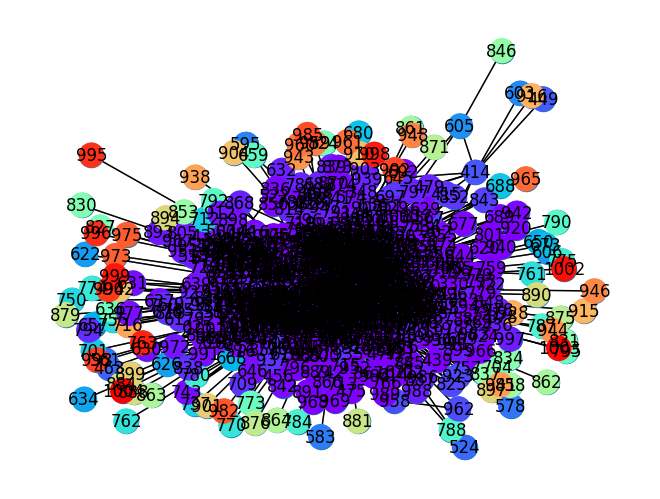

In [ ]:
walktrap = algorithms.walktrap(G_lastfm)
walktrap_df, walktrap_metrics = community_desc(walktrap.communities)

## Community Detection Comparison

### Congress Dataset

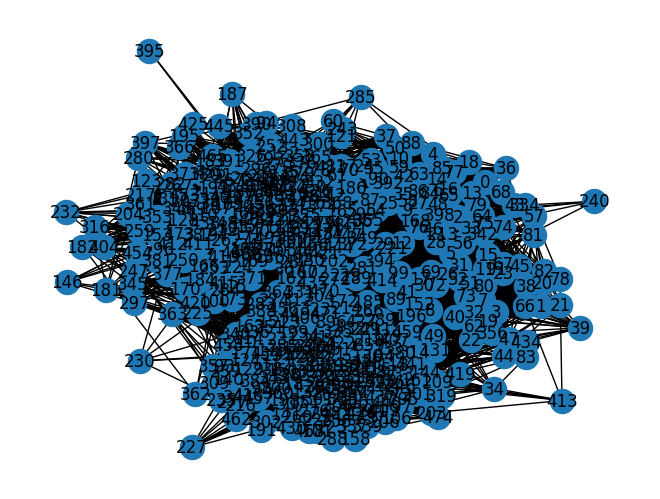

Number of clusters :  6
Louvain Algorithm : Done
Girvan Newman Algorithm : Done


Computing transition probabilities:   0%|          | 0/475 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


Creating Embeddings : Done
KMeans Clustering : Done
Agglomerative Clustering : Done


In [54]:
# Create graph with email dataset
G_congress = nx.read_edgelist('data/congress_network/congress.edgelist')

# Visualize the graph
nx.draw(G_congress, with_labels=True)
plt.show()

# # Specify the number of clusters (you may need to adjust this based on your graph)
results_congress, congress_df = run_community_detection(G_congress)
results_congress = results_congress.set_index('method')

In [55]:
congress_df

,louvain,girvan_newman,kMeans,agglomerative
3,4,1,104,116
0,9,470,50,54
5,17,1,66,24
2,90,1,103,44
4,162,1,108,142
1,193,1,44,95


In [57]:
results_congress[['modularity','partition_quality_coverage','partition_quality_performance', 'ratio_cut','time_elapsed']]

,modularity,partition_quality_coverage,partition_quality_performance,ratio_cut,time_elapsed
method,,,,,
louvain,0.442046,0.730385,0.724255,11.604211,0.204636
girvan_newman,-0.000006,0.997456,0.111304,0.109474,0.000005
k-means,0.376567,0.492663,0.814763,21.835789,0.865282
agglomerative,0.383434,0.525729,0.793267,20.412632,0.010528


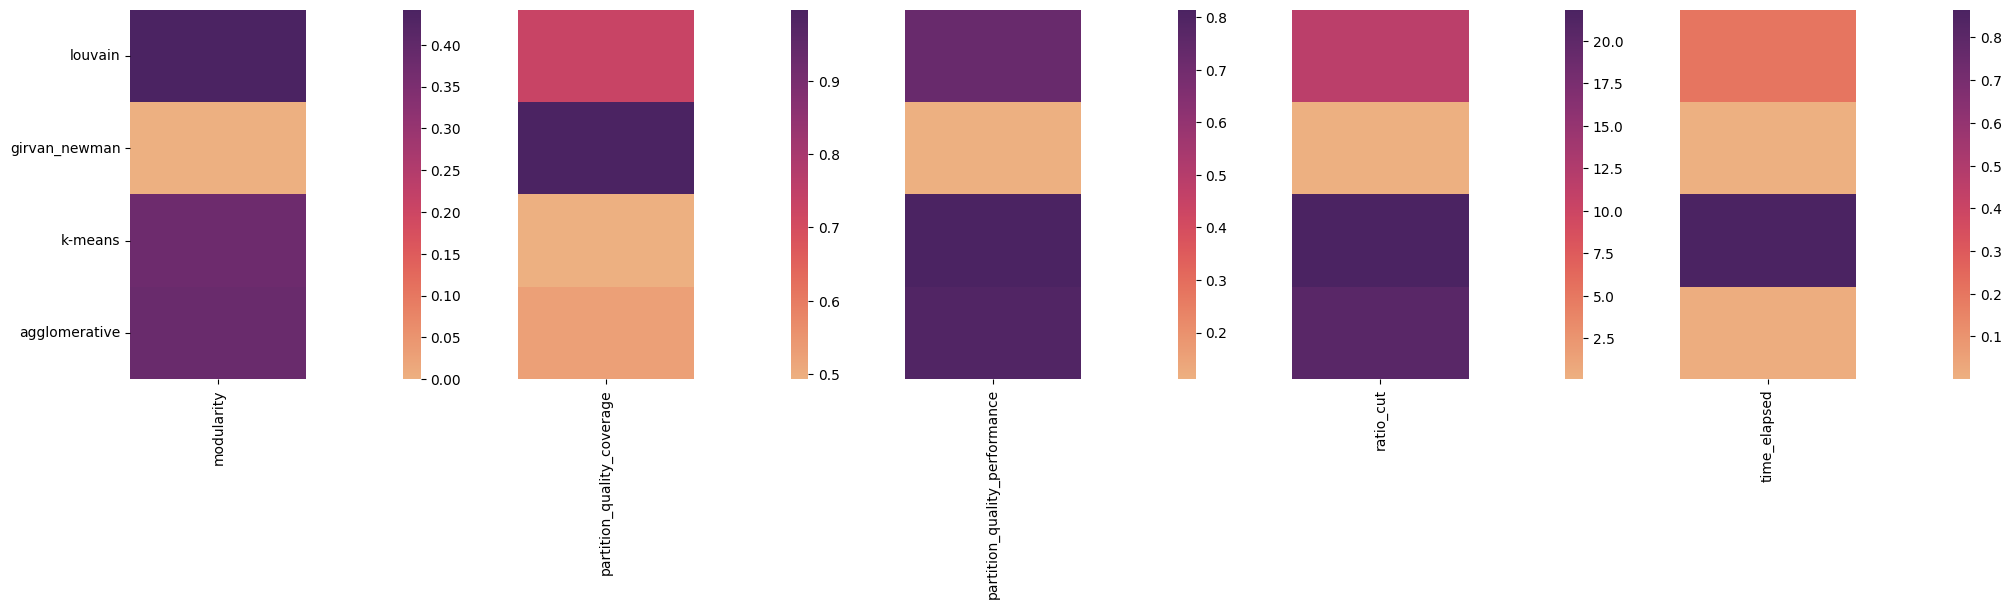

In [60]:
f,(ax1, axcb1, ax2, axcb2, ax3, axcb3 , ax4, axcb4, ax5, axcb5) = plt.subplots(1,10, 
            gridspec_kw={'width_ratios':[1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1]})
ax1.get_shared_y_axes().join(ax2,ax3,ax4, ax5)

g1 = sns.heatmap(results_congress[['modularity']],cmap="flare",cbar_ax=axcb1,ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g2 = sns.heatmap(results_congress[['partition_quality_coverage']],cmap="flare",cbar_ax=axcb2,ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g3 = sns.heatmap(results_congress[['partition_quality_performance']],cmap="flare",ax=ax3, cbar_ax=axcb3)
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_yticks([])
g4 = sns.heatmap(results_congress[['ratio_cut']],cmap="flare",ax=ax4, cbar_ax=axcb4)
g4.set_ylabel('')
g4.set_xlabel('')
g4.set_yticks([])
g5 = sns.heatmap(results_congress[['time_elapsed']],cmap="flare",ax=ax5, cbar_ax=axcb5)
g5.set_ylabel('')
g5.set_xlabel('')
g5.set_yticks([])
f.subplots_adjust(wspace=1,right=3)

for ax in [g1,g2,g3,g4,g5]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show() 


### Quality of Community Detection



### Runtime of Community Detection


### Email Dataset

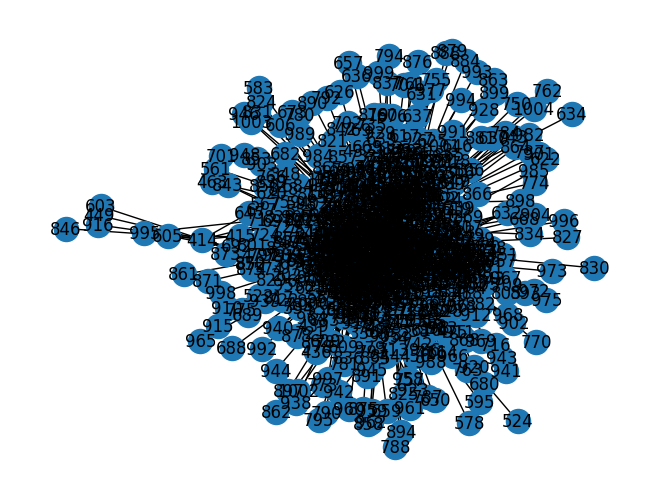

Number of clusters :  8
Louvain Algorithm : Done
Girvan Newman Algorithm : Done


Computing transition probabilities:   0%|          | 0/986 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Creating Embeddings : Done
KMeans Clustering : Done
Agglomerative Clustering : Done


In [45]:
# Create graph with email dataset
G_email = nx.from_pandas_edgelist(email_edges, 'node_1', 'node_2')

# Visualize the graph
nx.draw(G_email, with_labels=True)
plt.show()

# # Specify the number of clusters (you may need to adjust this based on your graph)
# num_clusters = 8
results_email, clusters_email = run_community_detection(G_email, truth)
results_email = results_email.set_index('method')

In [48]:
clusters_email

,louvain,girvan_newman,kMeans,agglomerative
0,57,974,142,155
5,75,1,107,54
2,94,1,343,83
7,108,1,12,160
1,123,6,92,94
4,131,1,56,84
6,145,1,98,250
3,253,1,136,106


In [49]:
results_email

,modularity,partition_quality_coverage,partition_quality_performance,ratio_cut,adj_rand_score,homogeneity_score,completeness_score,time_elapsed
method,,,,,,,,
louvain,0.414717,0.581647,0.855370,13.630832,0.339896,0.471378,0.789173,0.198953
girvan_newman,0.000622,0.999128,0.057195,0.028398,-0.000346,0.010993,0.428988,0.000005
k-means,0.407541,0.637863,0.815424,11.799189,0.261519,0.450948,0.819554,1.439777
agglomerative,0.390690,0.565959,0.851902,14.141988,0.301535,0.466542,0.784905,0.070458


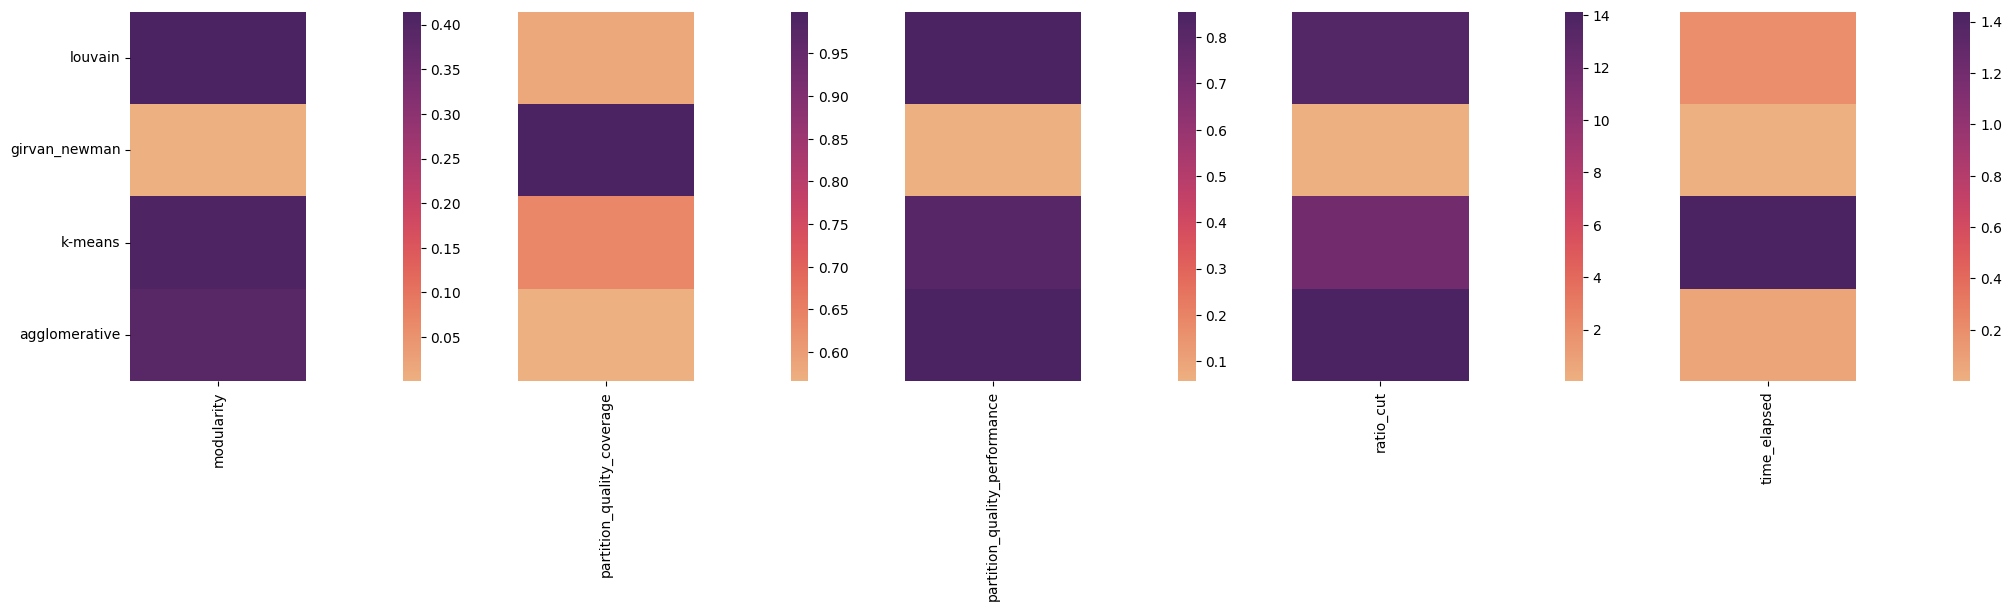

In [50]:
f,(ax1, axcb1, ax2, axcb2, ax3, axcb3 , ax4, axcb4, ax5, axcb5) = plt.subplots(1,10, 
            gridspec_kw={'width_ratios':[1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1]})
ax1.get_shared_y_axes().join(ax2,ax3,ax4, ax5)

g1 = sns.heatmap(results_email[['modularity']],cmap="flare",cbar_ax=axcb1,ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g2 = sns.heatmap(results_email[['partition_quality_coverage']],cmap="flare",cbar_ax=axcb2,ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g3 = sns.heatmap(results_email[['partition_quality_performance']],cmap="flare",ax=ax3, cbar_ax=axcb3)
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_yticks([])
g4 = sns.heatmap(results_email[['ratio_cut']],cmap="flare",ax=ax4, cbar_ax=axcb4)
g4.set_ylabel('')
g4.set_xlabel('')
g4.set_yticks([])
g5 = sns.heatmap(results_email[['time_elapsed']],cmap="flare",ax=ax5, cbar_ax=axcb5)
g5.set_ylabel('')
g5.set_xlabel('')
g5.set_yticks([])
f.subplots_adjust(wspace=1,right=3)

for ax in [g1,g2,g3,g4,g5]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show() 


### Quality of Community Detection

* **Girvan-Newman** approach partitions the graph into one large cluster (974 nodes), a small cluster (6 nodes) and then several single node clusters.
    * Hence less number of edges between the clusters
    * Large cluster -> High number of nodes in the same cluster -> Most of the edges reside within the same cluster -> **High coverage**
    * Less number of nodes in different clusters -> Less number of non-existing inter-community edges -> **Low partitioning performance**
    * Partitioning is close to random partitioning -> **Modularity close to 0**

* **Louvain, K-Means and Agglomerative** have a more balanced number of nodes in the clusters compared to the **Girvan-Newman** approach. 
    * Hence more inter-community edges than in **Girvan-Newman** clustering
    * Intra-community edges are less than in **Girvan-Newman** clustering -> **Low coverage**
    * More nodes in different clusters -> Higher potential of having more connections in between clusters -> **High partitioning performance**
    * Partitioning is better than a random partitioning -> Clusters are dense -> **Modularity around 0.4**

### Runtime of Community Detection
* Girvan-Newman performs the fastest even if it is known to have a higher time complexity
* K-Means clustering takes the longest time to run

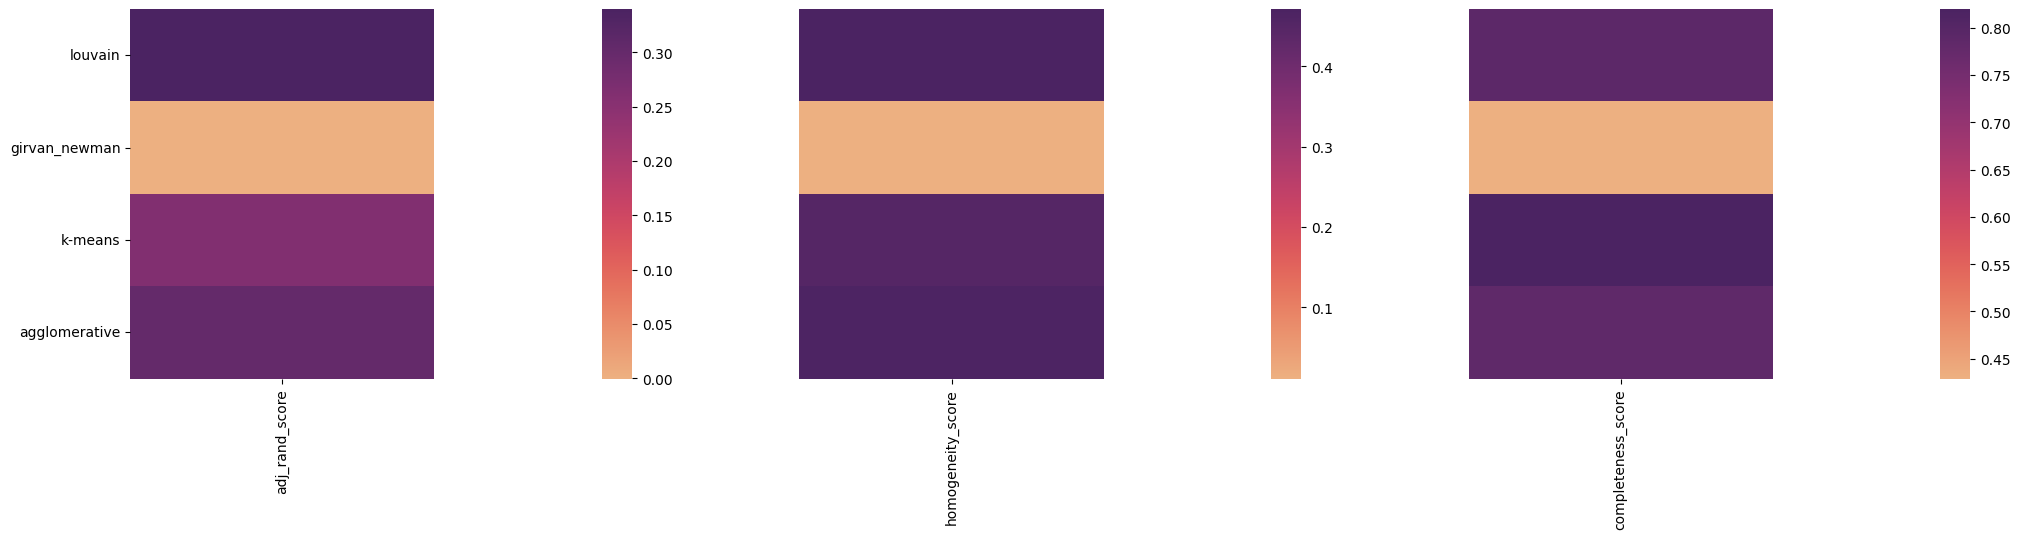

In [58]:
f,(ax1, axcb1, ax2, axcb2, ax3, axcb3 ) = plt.subplots(1,6, 
            gridspec_kw={'width_ratios':[1, 0.1, 1, 0.1, 1, 0.1]})
ax1.get_shared_y_axes().join(ax2,ax3,ax4, ax5)

g1 = sns.heatmap(results_email[['adj_rand_score']],cmap="flare",cbar_ax=axcb1,ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g2 = sns.heatmap(results_email[['homogeneity_score']],cmap="flare",cbar_ax=axcb2,ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g3 = sns.heatmap(results_email[['completeness_score']],cmap="flare",ax=ax3, cbar_ax=axcb3)
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_yticks([])

f.subplots_adjust(wspace=1,right=3)

for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.show() 


### Comparison with Ground Truth

### Comparison between Datasets